In [9]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
#이미지가 저장될 폴더가 없다면 만듭니다.
import os
if not os.path.exists("./gan_images"):
    os.makedirs("./gan_images")

In [11]:
# seed 값 설정
np.random.seed(42)
tf.random.set_seed(42)

생성자

In [12]:
# 생성자 모델 만들기
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
# 128 노드, 7*7 img, input_dim = 100 : 100차ㅏ원
generator.add(BatchNormalization()) # 배치정규화(평균 0, 분산 1)
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D()) # img 가로 세로 크기 2배 늘리기
generator.add(Conv2D(64, kernel_size=5, padding='same'))    # kernel_size=5 (filter size 5*5) / padding='same' (입출력 크기를 동일하게 (14*14 img))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2))) # 0 보다 작을 경우 : 0.2 곱해서 작은 출력 보기 위해
generator.add(UpSampling2D()) # 출력 수를 28*28 (mnist 원본 크기) img로 맞추기 위해서
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
# activation = tanh 사용 (-1 ~ 1) 상태 그대로 판별자(discriminator)에 넘겨서 크기가 일치한 상태로 만들기 위해

In [13]:
# 판별자 모델 만들기
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same'))  # input_shape=(28,28,1) : 28*28 img, 1 channel (흑백)
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=5, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())  # 차원축소
discriminator.add(Dense(1, activation='sigmoid')) # 이진 분류(참, 거짓)

# 환경설정 (compile)
discriminator.compile(loss='binary_crossentropy',
                      optimizer='adam')

discriminator.trainable=False
# (매우 중요)
# 판별자 자신이 학습하지 않도록 학습 기능 꺼줌

In [14]:
# 생성자, 판별자 모델 연결: gan 모델 생성

ginput = Input(shape=(100,))  # 무작위로 100개의 벡터 생성
dis_output = discriminator(generator(ginput))

gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', 
            optimizer='adam')
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_3 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_4 (Sequential)   (None, 1)                 207745    
                                                                 
Total params: 1,073,026
Trainable params: 852,609
Non-trainable params: 220,417
_________________________________________________________________


In [15]:
# 신경망 실행시키는 함수 생성
def gan_train(epoch, batch_size, saving_interval):
    # MNIST 데이터 불러오기
    # X_trian 만 호출
    (X_train, _), (_,_) = mnist.load_data()
    # 단 테스트 과정 없음, 이미지만 사용할 것임 >> X_train만 불러옴

    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    # 28*28 img, 색상 1(흑백)

    X_train = (X_train - 127.5) / 127.5    
    # pixel 값(흑백) : 0~255 사이 값
    # 255 나눈 것은 0~1 사이
    # 127.5 빼고 나누고 >> -1~1 사이 값

    true = np.ones((batch_size, 1)) # 모두가 참(1)인 실제 이미지 입력
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
        # 실제 데이터를 판별자에 입력
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        # 0~X_train.shape[0] 무작위 추출, batch_size 만큼 반복
        imgs = X_train[idx] # 선택된 숫자(idx)에 해당되는 이미지 불러옴
        d_loss_real = discriminator.train_on_batch(imgs, true)

        # 가상 이미지를 판별자에 입력
        noise = np.random.normal(0, 1, (batch_size, 100)) 
        # normal함수(평균 0, 분산 1), batch_size만큼 100열 추출
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        # 판별자와 생성자의 오차 계산
        d_loss = 0.5*np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)

        print('epoch: %d'%i, ' d_loss: %.4f'%d_loss, ' g_loss: %.4f'%g_loss)

        # 중간과정 이미지 저장 >> gan_images 폴더에 저장
        if i % saving_interval == 0:
            # r, c = 5, 5
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)
            
            # Rescale images = 0 ~ 1
            gen_imgs = 0.5*gen_imgs + 0.5

            fig, axs = plt.subplots(5,5)

            count = 0 # 초기값 설정

            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count+=1
            
            fig.savefig('gan_images/gan_mnist_%d.png'%i)

11501568/11490434 [==============================] - 0s 0us/step
epoch: 0  d_loss: 0.6726  g_loss: 0.5917
epoch: 1  d_loss: 0.4645  g_loss: 0.2808
epoch: 2  d_loss: 0.4605  g_loss: 0.0733
epoch: 3  d_loss: 0.5810  g_loss: 0.0318
epoch: 4  d_loss: 0.6563  g_loss: 0.0314
epoch: 5  d_loss: 0.6385  g_loss: 0.0769
epoch: 6  d_loss: 0.5436  g_loss: 0.1877
epoch: 7  d_loss: 0.4859  g_loss: 0.4149
epoch: 8  d_loss: 0.4658  g_loss: 0.5870
epoch: 9  d_loss: 0.4683  g_loss: 0.7596
epoch: 10  d_loss: 0.4353  g_loss: 0.8536
epoch: 11  d_loss: 0.4008  g_loss: 0.9673
epoch: 12  d_loss: 0.3905  g_loss: 0.9828
epoch: 13  d_loss: 0.3241  g_loss: 1.0097
epoch: 14  d_loss: 0.3183  g_loss: 1.0338
epoch: 15  d_loss: 0.3310  g_loss: 1.0833
epoch: 16  d_loss: 0.4420  g_loss: 0.9809
epoch: 17  d_loss: 0.5212  g_loss: 1.0523
epoch: 18  d_loss: 0.6756  g_loss: 1.0995
epoch: 19  d_loss: 0.5935  g_loss: 0.9870
epoch: 20  d_loss: 0.5888  g_loss: 0.8570
epoch: 21  d_loss: 0.6394  g_loss: 0.8021
epoch: 22  d_loss: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


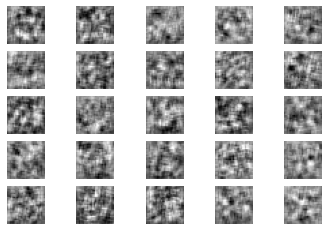

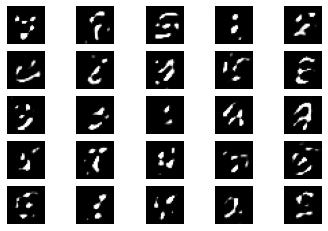

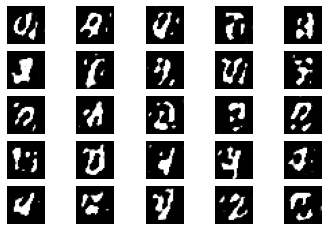

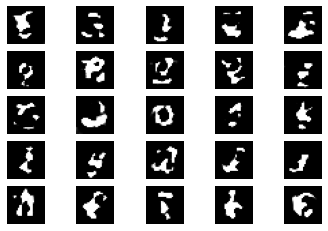

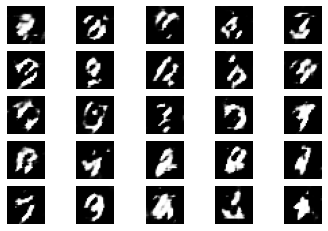

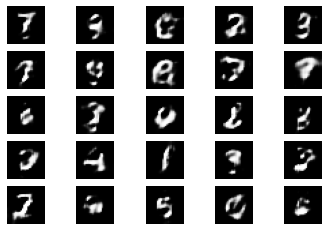

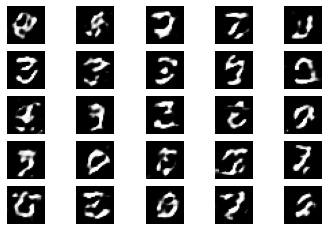

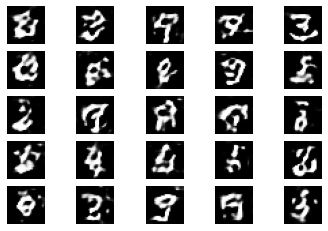

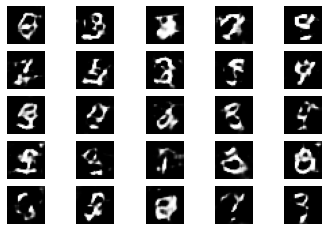

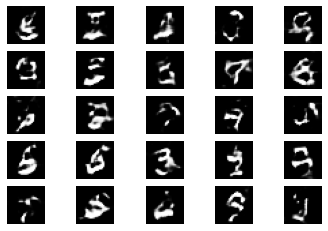

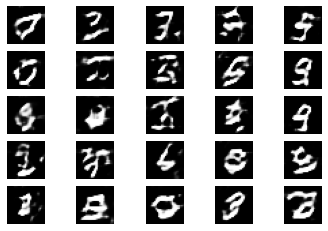

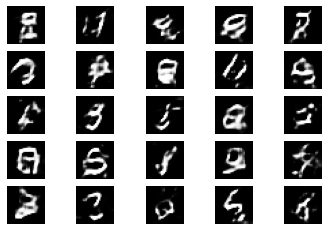

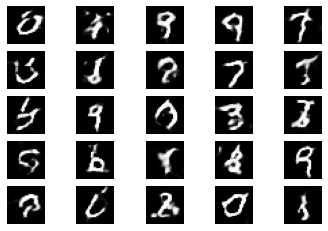

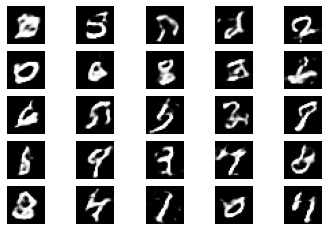

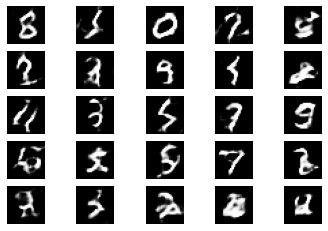

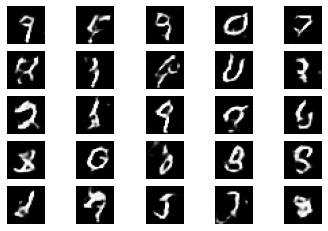

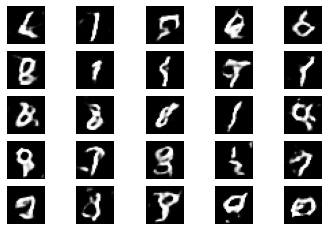

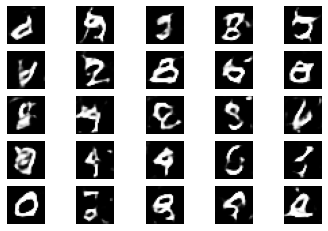

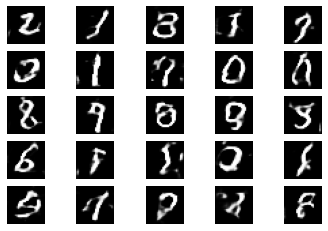

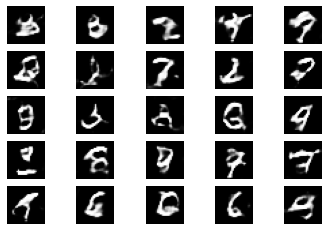

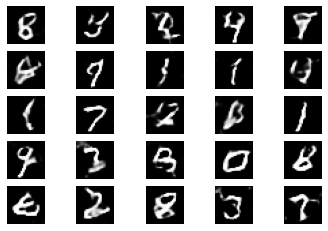

In [16]:
gan_train(4001, 32, 200)

# 4000번 반복하고, 배치사이즈 = 32, 200번마다 결과를 저장